In [160]:
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import plotly.express as px
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, LSTM, Dropout, Input
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

Trading Strategy Code for 1, 2, and 3

In [161]:
def trading_strategy1(predicted_prices, actual_prices):
    predicted_prices = np.atleast_1d(predicted_prices).flatten()
    actual_prices = np.atleast_1d(actual_prices).flatten()
    min_length = min(len(predicted_prices), len(actual_prices))
    predicted_prices = predicted_prices[:min_length]
    actual_prices = actual_prices[:min_length]
    signals = np.zeros_like(predicted_prices, dtype=int)
    buy_mask = predicted_prices > actual_prices
    signals[buy_mask] = 1
    sell_mask = predicted_prices < actual_prices
    signals[sell_mask] = -1
    
    return signals

In [162]:
def trading_strategy2(predicted_prices, actual_prices):
    predicted_prices = np.atleast_1d(predicted_prices).flatten()
    actual_prices = np.atleast_1d(actual_prices).flatten()
    min_length = min(len(predicted_prices), len(actual_prices))
    predicted_prices = predicted_prices[:min_length]
    actual_prices = actual_prices[:min_length]

    signals = np.zeros_like(predicted_prices, dtype=int)
    window_short = 5  
    window_long = 15  

    ma_short = np.zeros_like(predicted_prices)
    ma_long = np.zeros_like(predicted_prices)
    
    for i in range(len(predicted_prices)):
        start_short = max(0, i - window_short + 1)
        start_long = max(0, i - window_long + 1)
    
        ma_short[i] = np.mean(predicted_prices[start_short:i+1])
        ma_long[i] = np.mean(predicted_prices[start_long:i+1])

    for i in range(window_long + 1, len(predicted_prices)):
        buy_conditions = [ma_short[i] > ma_long[i], predicted_prices[i] > predicted_prices[i-1], predicted_prices[i] < ma_short[i] * 0.95, ma_short[i] - ma_short[i-1] > 0]

        sell_conditions = [ma_long[i] > ma_short[i], predicted_prices[i] < predicted_prices[i-1], predicted_prices[i] > ma_short[i] * 1.05, ma_short[i] - ma_short[i-1] < 0]
        if sum(buy_conditions) >= 3:
            signals[i] = 1
        elif sum(sell_conditions) >= 3:
            signals[i] = -1

    return signals

In [163]:
def trading_strategy3(predicted_prices, current_prices):
    predicted_prices = np.atleast_1d(predicted_prices).flatten()
    current_prices = np.atleast_1d(current_prices).flatten()

    signals = np.zeros_like(predicted_prices, dtype=int)
    min_length = min(len(predicted_prices), len(current_prices))
    predicted_prices = predicted_prices[:min_length]
    current_prices = current_prices[:min_length]
    buy_mask = predicted_prices > (current_prices * 1.04)
    signals[buy_mask] = 1
    sell_mask = predicted_prices < (current_prices * 0.96)
    signals[sell_mask] = -1
    
    return signals

RANDOMFORESTTIMESERIES Classifier


In [164]:
def optimize_crypto_profits(cryptos=["BTC-USD", "ETH-USD", "ADA-USD"], start_date="2020-01-01", end_date=None, train_ratio=0.7, test_ratio=0.3, features=['Open', 'High', 'Low', 'Close', 'Volume'], target='Close', prediction_horizon=1):
    if end_date is None:
        end_date = datetime.today().strftime('%Y-%m-%d')
    
    data_dfs = {}
    results = {}
    
    for crypto in cryptos:
        df = yf.download(crypto, start=start_date, end=end_date)
        total_len = len(df)
        train_end = int(total_len * train_ratio)
        test_end = train_end + int(total_len * test_ratio)
        train = df.iloc[:train_end]
        test = df.iloc[train_end:test_end]
        later_test = df.iloc[test_end:]

        def prepare_sequence_data(data, features, target, horizon):
            X = []
            y = []
            for i in range(len(data) - horizon):
                X.append(data[features].iloc[i].values)
                y.append(data[target].iloc[i + horizon])
            return np.array(X), np.array(y)
        
        X_train, y_train = prepare_sequence_data(train, features, target, prediction_horizon)
        
        X_test, y_test = prepare_sequence_data(test, features, target, prediction_horizon)
        
        min_len = min(len(X_test), len(y_test))
        X_test = X_test[:min_len]
        y_test = y_test[:min_len]
        
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        rf_model = RandomForestRegressor(n_estimators=1000, random_state=8, max_depth=10)
        rf_model.fit(X_train_scaled, y_train)

        y_pred = rf_model.predict(X_test_scaled)
        
        mse = mean_squared_error(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        
        trading_signals = trading_strategy1(y_pred,y_test)
        price_changes = y_test[1:] - y_test[:-1]
        trading_signals = trading_signals[:-1]
        profits = trading_signals * price_changes
        
        results[crypto] = {
            'model': rf_model,
            'scaler': scaler,
            'metrics': {
                'MSE': mse,
                'MAE': mae,
                'Total Profit': np.sum(profits),
                'Average Daily Profit': np.mean(profits),
                'Profit Standard Deviation': np.std(profits)
            },
            'predictions': y_pred,
            'actual_values': y_test,
            'trading_signals': trading_signals
        }
    
    return results

def main():
    crypto_results = optimize_crypto_profits()
    for crypto, result in crypto_results.items():
        print(f"\nResults for {crypto}:")
        print("Performance Metrics:")
        for metric, value in result['metrics'].items():
            print(f"{metric}: {value}")
        print("\n")

if __name__ == "__main__":
    main()

[*********************100%***********************]  1 of 1 completed
c:\Users\christian fink\anaconda3\envs\skmob\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

[*********************100%***********************]  1 of 1 completed
c:\Users\christian fink\anaconda3\envs\skmob\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

[*********************100%***********************]  1 of 1 completed
c:\Users\christian fink\anaconda3\envs\skmob\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().




Results for BTC-USD:
Performance Metrics:
MSE: 71141401.70932643
MAE: 3612.68967764076
Total Profit: -13174977.5546875
Average Daily Profit: -45.014802992635325
Profit Standard Deviation: 1528.481515741922



Results for ETH-USD:
Performance Metrics:
MSE: 10178.708131792015
MAE: 68.88745196274152
Total Profit: -35004.3447265625
Average Daily Profit: -0.11959896517560928
Profit Standard Deviation: 86.76061307461705



Results for ADA-USD:
Performance Metrics:
MSE: 0.0007813393222451389
MAE: 0.01753559835668811
Total Profit: -15.299295097589493
Average Daily Profit: -5.2272935713590883e-05
Profit Standard Deviation: 0.023516948168333413




MLP Classifier 

In [165]:
def optimize_crypto_profits(cryptos=["BTC-USD", "ETH-USD", "ADA-USD"], start_date="2020-01-01", end_date=None, train_ratio=0.7, test_ratio=0.3, features=['Open', 'High', 'Low', 'Close', 'Volume'], target='Close', prediction_horizon=1):
    if end_date is None:
        end_date = datetime.today().strftime('%Y-%m-%d')
    
    data_dfs = {}
    results = {}
    
    for crypto in cryptos:
        df = yf.download(crypto, start=start_date, end=end_date)
        total_len = len(df)
        train_end = int(total_len * train_ratio)
        test_end = train_end + int(total_len * test_ratio)
        train = df.iloc[:train_end]
        test = df.iloc[train_end:test_end]
        later_test = df.iloc[test_end:]

        def prepare_sequence_data(data, features, target, horizon):
            X = []
            y = []
            for i in range(len(data) - horizon):
                X.append(data[features].iloc[i].values)
                price_change = data[target].iloc[i + horizon].item() - data[target].iloc[i].item()
                y.append(1 if price_change > 0 else 0)
            return np.array(X), np.array(y)

        X_train, y_train = prepare_sequence_data(train, features, target, prediction_horizon)
        
        X_test, y_test = prepare_sequence_data(test, features, target, prediction_horizon)

        min_len = min(len(X_test), len(y_test))
        X_test = X_test[:min_len]
        y_test = y_test[:min_len]

        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        mlp_model = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=8, learning_rate_init=0.001, activation='relu')
        mlp_model.fit(X_train_scaled, y_train)

        y_pred = mlp_model.predict(X_test_scaled)

        mse = mean_squared_error(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
    
        trading_signals = trading_strategy1(y_pred,y_test)
        
        price_changes = test[target].iloc[prediction_horizon:].values - test[target].iloc[:-prediction_horizon].values

        trading_signals = trading_signals[:len(price_changes)]
        profits = trading_signals * price_changes
        
        results[crypto] = {
            'model': mlp_model,
            'scaler': scaler,
            'metrics': {
                'MSE': mse,
                'MAE': mae,
                'Total Potential Profit': np.sum(profits),
                'Average Daily Profit': np.mean(profits),
                'Profit Standard Deviation': np.std(profits)
            },
            'predictions': y_pred,
            'actual_values': y_test,
            'trading_signals': trading_signals
        }
    
    return results

def main():
    crypto_results = optimize_crypto_profits()
    
    for crypto, result in crypto_results.items():
        print(f"\nResults for {crypto}:")
        print("Performance Metrics:")
        for metric_name, metric_value in result['metrics'].items():
            print(f"{metric_name}:")
            if isinstance(metric_value, (int, float)):
                print(f"  {metric_value}")
            else:
                print(f"  {metric_value}")
        print("\n")

if __name__ == "__main__":
    main()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed



Results for BTC-USD:
Performance Metrics:
MSE:
  0.522140221402214
MAE:
  0.522140221402214
Total Potential Profit:
  -12422531.1484375
Average Daily Profit:
  -42.287452337377964
Profit Standard Deviation:
  1103.3862407303207



Results for ETH-USD:
Performance Metrics:
MSE:
  0.477859778597786
MAE:
  0.477859778597786
Total Potential Profit:
  -31184.972534179688
Average Daily Profit:
  -0.10615654925103038
Profit Standard Deviation:
  59.922886755103335



Results for ADA-USD:
Performance Metrics:
MSE:
  0.4870848708487085
MAE:
  0.4870848708487085
Total Potential Profit:
  -163.90179991722107
Average Daily Profit:
  -0.0005579369831470877
Profit Standard Deviation:
  0.01638926407769069




SEQUENTIAL TENSORFLOW Classifier

In [166]:
def optimize_crypto_profits(cryptos=["BTC-USD", "ETH-USD", "ADA-USD"], start_date="2020-01-01", end_date=None, 
                             train_ratio=0.7, test_ratio=0.3, features=['Open', 'High', 'Low', 'Close', 'Volume'], 
                             target='Close', prediction_horizon=1, lstm_units=50, dropout_rate=0.2):
    if end_date is None:
        end_date = datetime.today().strftime('%Y-%m-%d')
    
    data_dfs = {}
    results = {}
    
    for crypto in cryptos:
        df = yf.download(crypto, start=start_date, end=end_date)
        total_len = len(df)
        train_end = int(total_len * train_ratio)
        test_end = train_end + int(total_len * test_ratio)
        train = df.iloc[:train_end]
        test = df.iloc[train_end:test_end]
        later_test = df.iloc[test_end:]

        def prepare_sequence_data(data, features, target, horizon):
            X = []
            y = []
            for i in range(len(data) - horizon):
                X.append(data[features].iloc[i:i+horizon].values)
                y.append(data[target].iloc[i + horizon])
            return np.array(X), np.array(y)
        
        X_train, y_train = prepare_sequence_data(train, features, target, prediction_horizon)
        X_test, y_test = prepare_sequence_data(test, features, target, prediction_horizon)
        min_len = min(len(X_test), len(y_test))
        X_test = X_test[:min_len]
        y_test = y_test[:min_len]
        
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
        X_test_scaled = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)
        
        model = tf.keras.Sequential([
            tf.keras.layers.LSTM(lstm_units, input_shape=(X_train.shape[1], X_train.shape[2]), 
                                  return_sequences=False),
            tf.keras.layers.Dropout(dropout_rate),
            tf.keras.layers.Dense(32, activation='relu'),
            tf.keras.layers.Dense(1)
        ])
        
        model.compile(optimizer='adam', loss='mean_squared_error')
        model.fit(X_train_scaled, y_train, epochs=50, batch_size=32, verbose=0)
        y_pred = model.predict(X_test_scaled).flatten()
        
        mse = mean_squared_error(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        
        trading_signals = trading_strategy1(y_pred,y_test)
        price_changes = y_test[1:] - y_test[:-1]
        trading_signals = trading_signals[:-1]
        profits = trading_signals * price_changes
        
        results[crypto] = {
            'model': model,
            'scaler': scaler,
            'metrics': {
                'MSE': mse,
                'MAE': mae,
                'Total Potential Profit': np.sum(profits),
                'Average Daily Profit': np.mean(profits),
                'Profit Standard Deviation': np.std(profits)
            },
            'predictions': y_pred,
            'actual_values': y_test,
            'trading_signals': trading_signals
        }
    
    return results

def main():
    np.random.seed(8)
    tf.random.set_seed(8)
    crypto_results = optimize_crypto_profits()
    for crypto, result in crypto_results.items():
        print(f"\nResults for {crypto}:")
        print("Performance Metrics:")
        for metric, value in result['metrics'].items():
            print(f"{metric}: {value}")
        print("\n")

if __name__ == "__main__":
    main()

[*********************100%***********************]  1 of 1 completed
c:\Users\christian fink\anaconda3\envs\skmob\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step


[*********************100%***********************]  1 of 1 completed
c:\Users\christian fink\anaconda3\envs\skmob\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step


[*********************100%***********************]  1 of 1 completed
c:\Users\christian fink\anaconda3\envs\skmob\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step

Results for BTC-USD:
Performance Metrics:
MSE: 2586985091.9389515
MAE: 47171.7071501672
Total Potential Profit: -39819345.5703125
Average Daily Profit: -136.05032636321627
Profit Standard Deviation: 1523.0799011048803



Results for ETH-USD:
Performance Metrics:
MSE: 164899.65690463828
MAE: 339.843601578716
Total Potential Profit: 232675.9384765625
Average Daily Profit: 0.7949813567555205
Profit Standard Deviation: 86.75705325584943



Results for ADA-USD:
Performance Metrics:
MSE: 0.000638637132951303
MAE: 0.01487487037683325
Total Potential Profit: -42.676981061697006
Average Daily Profit: -0.00014581397856949034
Profit Standard Deviation: 0.023516554209652867




VISUALIZATION

Calculating Averages to Normalize all Data

In [167]:
cryptos = ["BTC-USD", "ETH-USD", "ADA-USD"]
start_date = "2020-01-01"
end_date = datetime.today().strftime('%Y-%m-%d')

data_dfs = {}
for crypto in cryptos:
    data_dfs[crypto] = yf.download(crypto, start=start_date, end=end_date)

btc_df = data_dfs["BTC-USD"]
eth_df = data_dfs["ETH-USD"] 
ada_df = data_dfs["ADA-USD"] 

average_prices = {}
for crypto, df in data_dfs.items():
    avg_price = df['Close'].mean()  
    average_prices[crypto] = avg_price
average_prices

[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


{'BTC-USD': Ticker
 BTC-USD    35817.148119
 dtype: float64,
 'ETH-USD': Ticker
 ETH-USD    1970.323354
 dtype: float64,
 'ADA-USD': Ticker
 ADA-USD    0.618368
 dtype: float64}

In [168]:
btc_df.columns = btc_df.columns.droplevel(1) 
btc_df.reset_index(inplace=True)
fig = px.line(btc_df, x="Date", y=btc_df["Close"].values.flatten(), title="BTC-USD Training Data: Close Prices Over Time")
fig.show()

In [169]:
eth_df.columns = eth_df.columns.droplevel(1) 
eth_df.reset_index(inplace=True)
fig = px.line(eth_df, x="Date", y=eth_df["Close"].values.flatten(), title="ETH-USD Training Data: Close Prices Over Time")
fig.show()

In [170]:
ada_df.columns = ada_df.columns.droplevel(1) 
ada_df.reset_index(inplace=True)
fig = px.line(ada_df, x="Date", y=ada_df["Close"].values.flatten(), title="ADA-USD Training Data: Close Prices Over Time")
fig.show()

In [171]:
def trading_strategy1(data):
    # Calculate the 30-day Simple Moving Average (SMA)
    data['SMA_30'] = data['Close'].rolling(window=30).mean()
    # Define buy and sell signals
    data['Signal'] = None   
    # Buy signal: close > open and > SMA
    data.loc[(data['Close'] > data['Open']) & (data['Close'] > data['SMA_30']), 'Signal'] = 'Buy'
    # Sell signal: open > close and < SMA
    data.loc[(data['Open'] > data['Close']) & (data['Close'] < data['SMA_30']), 'Signal'] = 'Sell'
    # Shift signals by one day to reflect actions for the next day
    data['Action'] = data['Signal'].shift(-1)
    return data

In [172]:
def trading_strategy2(data):
    # Calculate the 10-day Faster Moving Average and 30-day Slower Moving Average
    data['FMA_10'] = data['Close'].rolling(window=10).mean()
    data['SMA_30'] = data['Close'].rolling(window=30).mean()
    # Calculate Bollinger Bands (20-day SMA and standard deviation by default)
    data['BB_Middle'] = data['Close'].rolling(window=20).mean()
    data['BB_StdDev'] = data['Close'].rolling(window=20).std()
    data['BB_Upper'] = data['BB_Middle'] + (2 * data['BB_StdDev'])
    data['BB_Lower'] = data['BB_Middle'] - (2 * data['BB_StdDev'])
    # Define buy and sell signals
    data['Signal'] = None 
    # Buy signal: FMA > SMA and Open, Close, or Low < Lower Bollinger Band
    data.loc[
        (data['FMA_10'] > data['SMA_30']) &
        ((data['Open'] < data['BB_Lower']) | (data['Close'] < data['BB_Lower']) | (data['Low'] < data['BB_Lower'])),'Signal'] = 'Buy'
    # Sell signal: SMA > FMA and Open, Close, or High > Upper Bollinger Band
    data.loc[
        (data['SMA_30'] > data['FMA_10']) &
        ((data['Open'] > data['BB_Upper']) | (data['Close'] > data['BB_Upper']) | (data['High'] > data['BB_Upper'])),'Signal'] = 'Sell'
    # Shift signals by one day to reflect actions for the next day
    data['Action'] = data['Signal'].shift(-1)
    return data

In [173]:
def trading_strategy3(data):
    # Calculate All-Time High
    data['All_Time_High'] = data['High'].cummax()
    # Calculate Drawdown
    data['Drawdown'] = data['All_Time_High'] - data['Close']
    # Define buy and sell signals
    data['Signal'] = None  # Default value
    # Buy signal: Drawdown = 0.05 * All-Time High
    data.loc[
        data['Drawdown'] >= 0.05 * data['All_Time_High'],'Signal'] = 'Buy'
    # Sell signal: Open, Close, or High = All-Time High
    data.loc[
        (data['Open'] == data['All_Time_High']) | 
        (data['Close'] == data['All_Time_High']) | 
        (data['High'] == data['All_Time_High']),'Signal'] = 'Sell'
    # Shift signals by one day to reflect actions for the next day
    data['Action'] = data['Signal'].shift(-1)
    return data

[*********************100%***********************]  1 of 1 completed
C:\Users\christian fink\AppData\Local\Temp\ipykernel_14572\3621430920.py:24: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

C:\Users\christian fink\AppData\Local\Temp\ipykernel_14572\3621430920.py:24: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



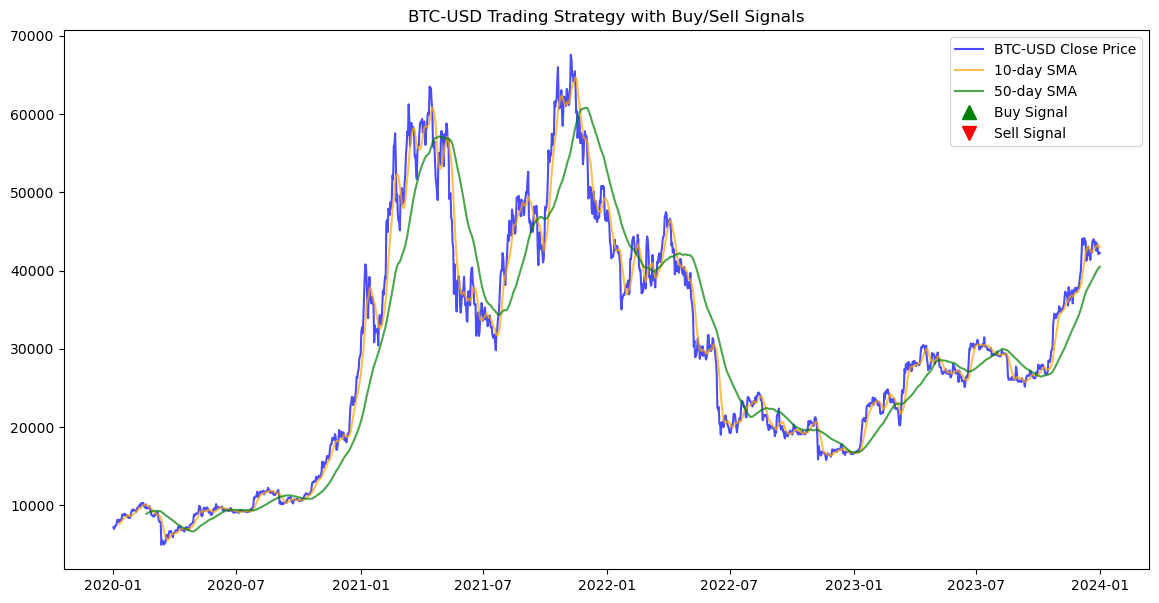

In [174]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

# Download the data (replace with the desired crypto symbol)
cryptos = ["BTC-USD"]  # Add more cryptocurrencies as needed
start_date = "2020-01-01"
end_date = "2024-01-01"

# Load data
data_dfs = {}
for crypto in cryptos:
    data_dfs[crypto] = yf.download(crypto, start=start_date, end=end_date)

# Choose one of the crypto dataframes
btc = data_dfs["BTC-USD"]

# Calculate short and long moving averages
btc['SMA10'] = btc['Close'].rolling(window=10).mean()
btc['SMA50'] = btc['Close'].rolling(window=50).mean()

# Generate buy/sell signals
btc['Signal'] = 0
btc['Signal'][10:] = [1 if btc['SMA10'][i] > btc['SMA50'][i] else -1 for i in range(10, len(btc))]
btc['Position'] = btc['Signal'].diff()

# Plot the data
plt.figure(figsize=(14, 7))
plt.plot(btc['Close'], label="BTC-USD Close Price", color='blue', alpha=0.7)
plt.plot(btc['SMA10'], label="10-day SMA", color='orange', alpha=0.7)
plt.plot(btc['SMA50'], label="50-day SMA", color='green', alpha=0.7)

# Mark Buy and Sell signals
plt.plot(btc[btc['Position'] == 1].index, 
         btc['SMA10'][btc['Position'] == 1], 
         '^', markersize=10, color='g', lw=0, label='Buy Signal')

plt.plot(btc[btc['Position'] == -1].index, 
         btc['SMA10'][btc['Position'] == -1], 
         'v', markersize=10, color='r', lw=0, label='Sell Signal')

plt.title('BTC-USD Trading Strategy with Buy/Sell Signals')
plt.legend(loc='best')
plt.show()


In [175]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np

# Download data (replace with the desired crypto symbol)
cryptos = ["BTC-USD"]  # Add more cryptocurrencies as needed
start_date = "2020-01-01"
end_date = "2024-01-01"

# Load data
data_dfs = {}
for crypto in cryptos:
    data_dfs[crypto] = yf.download(crypto, start=start_date, end=end_date)

# Choose one of the crypto dataframes
btc = data_dfs["BTC-USD"]

# Calculate moving averages (EMA)
btc['EMA10'] = btc['Close'].ewm(span=10, adjust=False).mean()
btc['EMA50'] = btc['Close'].ewm(span=50, adjust=False).mean()

# Calculate RSI (14-period)
delta = btc['Close'].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()

rs = gain / loss
btc['RSI'] = 100 - (100 / (1 + rs))

# Generate signals
btc['Signal'] = 0
btc['Signal'] = np.where((btc['EMA10'] > btc['EMA50']) & (btc['RSI'] < 70) & (btc['RSI'] > 30), 1, 0)  # Buy signal
btc['Signal'] = np.where((btc['EMA10'] < btc['EMA50']) & (btc['RSI'] < 70) & (btc['RSI'] > 30), -1, btc['Signal'])  # Sell signal

# Backtest the strategy
btc['Position'] = btc['Signal'].shift()
btc['Daily Returns'] = btc['Close'].pct_change()
btc['Strategy Returns'] = btc['Daily Returns'] * btc['Position']

# Track trades with stop-loss and take-profit
btc['Entry Price'] = np.nan
btc['Stop Loss'] = np.nan
btc['Take Profit'] = np.nan

# Implement stop-loss and take-profit
stop_loss_pct = 0.03  # 3% stop-loss
take_profit_pct = 0.06  # 6% take-profit

# Modify the stop-loss and take-profit tracking
for i in range(1, len(btc)):
    if btc['Position'].iloc[i] == 1:  # Buy signal
        entry_price = btc['Close'].iloc[i]
        btc.loc[btc.index[i], 'Entry Price'] = entry_price
        btc.loc[btc.index[i], 'Stop Loss'] = entry_price * (1 - stop_loss_pct)
        btc.loc[btc.index[i], 'Take Profit'] = entry_price * (1 + take_profit_pct)
    elif btc['Position'].iloc[i] == -1:  # Sell signal
        btc.loc[btc.index[i], 'Entry Price'] = np.nan
        btc.loc[btc.index[i], 'Stop Loss'] = np.nan
        btc.loc[btc.index[i], 'Take Profit'] = np.nan

# Alternative method to create stop-loss and take-profit flags
btc['Stop Loss Met'] = ((btc['Stop Loss'].notna()) & (btc['Close'] <= btc['Stop Loss'])).astype(bool)
btc['Take Profit Met'] = ((btc['Take Profit'].notna()) & (btc['Close'] >= btc['Take Profit'])).astype(bool)

# Assign to DataFrame columns
btc['Stop Loss Met'] = stop_loss_met
btc['Take Profit Met'] = take_profit_met

# Plot the strategy results
plt.figure(figsize=(14, 7))
plt.plot(btc['Close'], label="BTC-USD Close Price", color='blue', alpha=0.7)
plt.plot(btc['EMA10'], label="10-day EMA", color='orange', alpha=0.7)
plt.plot(btc['EMA50'], label="50-day EMA", color='green', alpha=0.7)

# Mark Buy and Sell signals
plt.plot(btc[btc['Position'] == 1].index, 
         btc['EMA10'][btc['Position'] == 1], 
         '^', markersize=10, color='g', lw=0, label='Buy Signal')

plt.plot(btc[btc['Position'] == -1].index, 
         btc['EMA10'][btc['Position'] == -1], 
         'v', markersize=10, color='r', lw=0, label='Sell Signal')

# Mark Stop-Loss and Take-Profit
plt.plot(btc[btc['Stop Loss Met'] == True].index, 
         btc['Stop Loss'][btc['Stop Loss Met'] == True], 
         'x', markersize=10, color='black', lw=0, label='Stop Loss')

plt.plot(btc[btc['Take Profit Met'] == True].index, 
         btc['Take Profit'][btc['Take Profit Met'] == True], 
         's', markersize=10, color='purple', lw=0, label='Take Profit')

plt.title('BTC-USD Trading Strategy with Buy/Sell/Stop-Loss/Take-Profit Signals')
plt.legend(loc='best')
plt.show()

# Strategy performance (cumulative returns)
btc['Cumulative Strategy Returns'] = (1 + btc['Strategy Returns']).cumprod() - 1
plt.figure(figsize=(14, 7))
plt.plot(btc['Cumulative Strategy Returns'], label='Strategy Returns')
plt.title('Cumulative Strategy Returns')
plt.legend(loc='best')
plt.show()


[*********************100%***********************]  1 of 1 completed


ValueError: Operands are not aligned. Do `left, right = left.align(right, axis=1, copy=False)` before operating.

In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
import plotly.express as px
import matplotlib.pyplot as plt

# Download crypto data (Bitcoin as an example)
crypto = "BTC-USD"
start_date = "2020-01-01"
end_date = "2024-01-01"
data = yf.download(crypto, start=start_date, end=end_date)

# Calculate moving averages
data['Short_MA'] = data['Close'].rolling(window=20).mean()  # 20-day moving average
data['Long_MA'] = data['Close'].rolling(window=200).mean()  # 200-day moving average

# Generate signals based on open and close, moving averages, and price changes
data['Signal'] = 0  # Default to no signal
data['Signal'] = np.where((data['Close'] > data['Open']) & (data['Close'] > data['Short_MA']), 1, data['Signal'])  # Buy Signal
data['Signal'] = np.where((data['Close'] < data['Open']) & (data['Close'] < data['Long_MA']), -1, data['Signal'])  # Sell Signal

# Shift signals to align with future prices (signals for the next day)
data['Position'] = data['Signal'].shift(1)

# Set up the stop-loss and take-profit rules
data['Buy_Price'] = np.nan
data['Stop_Loss'] = np.nan
data['Take_Profit'] = np.nan

for i in range(1, len(data)):
    if data['Position'].iloc[i] == 1:  # Buy signal
        data['Buy_Price'].iloc[i] = data['Close'].iloc[i]
        data['Stop_Loss'].iloc[i] = data['Close'].iloc[i] * 0.97  # 3% stop loss
        data['Take_Profit'].iloc[i] = data['Close'].iloc[i] * 1.05  # 5% take profit
    elif data['Position'].iloc[i] == -1:  # Sell signal
        data['Buy_Price'].iloc[i] = np.nan
        data['Stop_Loss'].iloc[i] = np.nan
        data['Take_Profit'].iloc[i] = np.nan

# Check if stop-loss or take-profit conditions are met
data['Stop_Loss_Met'] = data['Close'] < data['Stop_Loss']
data['Take_Profit_Met'] = data['Close'] > data['Take_Profit']

# Visualize the strategy signals, stop-loss, and take-profit on the price chart
fig = px.line(data, x=data.index, y="Close", title="Crypto Trading Strategy with Stop-Loss and Take-Profit")

# Add Buy and Sell Signals
fig.add_scatter(x=data.index[data['Position'] == 1], y=data['Close'][data['Position'] == 1],
                mode='markers', marker=dict(symbol='triangle-up', color='green', size=10), name='Buy Signal')
fig.add_scatter(x=data.index[data['Position'] == -1], y=data['Close'][data['Position'] == -1],
                mode='markers', marker=dict(symbol='triangle-down', color='red', size=10), name='Sell Signal')

# Add Stop Loss and Take Profit Lines
fig.add_scatter(x=data.index[data['Stop_Loss_Met'] == True], y=data['Stop_Loss'][data['Stop_Loss_Met'] == True],
                mode='markers', marker=dict(symbol='x', color='red', size=10), name='Stop Loss Met')
fig.add_scatter(x=data.index[data['Take_Profit_Met'] == True], y=data['Take_Profit'][data['Take_Profit_Met'] == True],
                mode='markers', marker=dict(symbol='x', color='green', size=10), name='Take Profit Met')

fig.show()

# Display the strategy results
data[['Open', 'Close', 'Short_MA', 'Long_MA', 'Position', 'Buy_Price', 'Stop_Loss', 'Take_Profit']].tail(10)
